In [33]:
%matplotlib inline
import os
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def spark_start(project_path, metastore=None):
    from pyspark.sql import SparkSession

    warehouse_location = os.path.join(project_path, 'spark-warehouse')

    local_dir = "/epyc/users/ctslater/spark-temp"

    spark = ( 
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", warehouse_location)
            .config('spark.master', "local[12]")
            .config('spark.driver.memory', '16G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '16G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "16G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={metastore}")
            .enableHiveSupport()
            .getOrCreate()
                    )   

    return spark

In [3]:
spark = spark_start("/epyc/users/ctslater/", metastore='/epyc/users/ctslater/metastore_db')

In [5]:
gaia_ = spark.read.parquet("/epyc/projects/lsd2/pzwarehouse/gaia_zoned1am_dup_hd/")
gaia = gaia_.withColumn("hpix12", gaia_['source_id']/34359738368)

In [14]:
def healpix_hist(input_df, NSIDE=64, groupby=[],
                 agg={"*": "count"}, returnDf=False):
    from pyspark.sql.functions import floor as FLOOR, col as COL, lit, shiftRight

    order0 = 12
    order  = hp.nside2order(NSIDE)
    shr    = 2*(order0 - order)

    # construct query
    df = input_df.withColumn('hpix__', shiftRight('hpix12', shr))
    gbcols = ('hpix__', )
    for axspec in groupby:
        if not isinstance(axspec, str):
            (col, c0, c1, dc) = axspec
            df = ( df
                .where((lit(c0) < COL(col)) & (COL(col) < lit(c1)))
                .withColumn(col + '_bin__', FLOOR((COL(col) - lit(c0)) / lit(dc)) * lit(dc) + lit(c0) )
                 )
            gbcols += ( col + '_bin__', )
        else:
            gbcols += ( axspec, )
    df = df.groupBy(*gbcols)

    # execute aggregation
    df = df.agg(agg)

    # fetch result
    df = df.toPandas()
    if returnDf == 'raw':
        return df

    # repack the result into maps
    results = [ f"{v}({k})" if k != "*" else f"{v}(1)" for k, v in agg.items() ]    # Result columns
    def _create_map(df):
        maps = dict()
        for val in results:
            map_ = np.zeros(hp.nside2npix(NSIDE))
            map_[df.hpix__.values] = df[val].values
            maps[val] = [ map_ ]
        return pd.DataFrame(data=maps)

    idxcols = list(gbcols[1:])
    if len(idxcols) == 0:
        ret = _create_map(df)
        assert(len(ret) == 1)
        if not returnDf:
            # convert to tuple, or scalar
            ret = tuple(ret[name].values[0] for name in results)
            if len(ret) == 1:
                ret = ret[0]
    else:
        ret = df.groupby(idxcols).apply(_create_map)
        ret.index = ret.index.droplevel(-1)
        ret.index.rename([ name.split("_bin__")[0] for name in ret.index.names ], inplace=True)
        if "count(1)" in ret:
                    ret = ret.rename(columns={'count(1)': 'count'})
        if not returnDf:
            if len(ret.columns) == 1:
                ret = ret.iloc[:, 0]
    return ret

In [16]:
%%time

map_ = healpix_hist(gaia, NSIDE=512)

CPU times: user 99.1 ms, sys: 47.5 ms, total: 147 ms
Wall time: 29.6 s


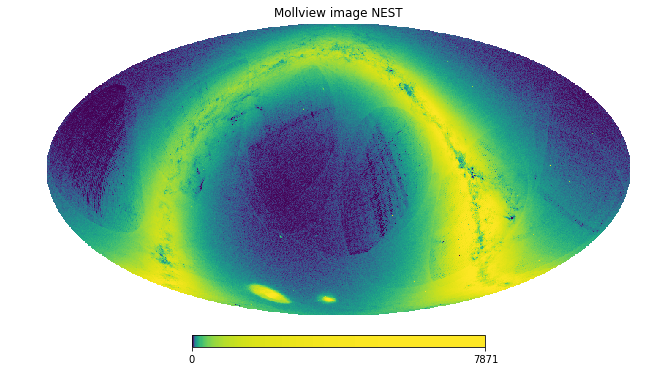

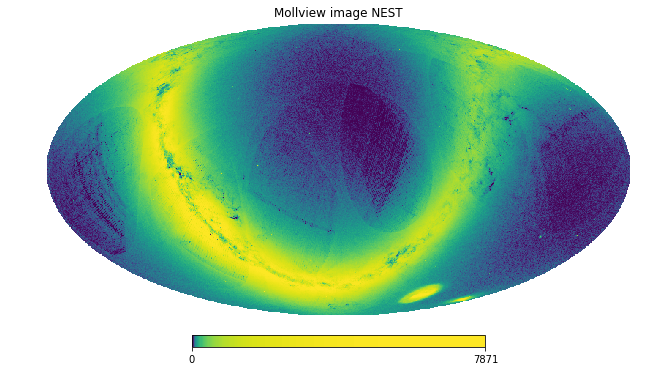

In [23]:
hp.mollview(map_, title="Mollview image NEST", rot=(0, 0, 0), nest=True, norm='hist')
plt.show()
hp.mollview(map_, title="Mollview image NEST", rot=(180, 0, 0), nest=True, norm='hist')

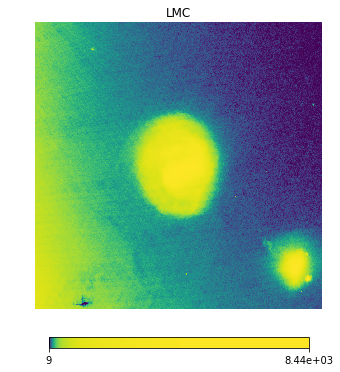

In [25]:
hp.cartview(map_, title="LMC",
            rot=(82, -69, 0),
            lonra=(-20, 20), latra=(-20, 20),
            nest=True, norm='hist')

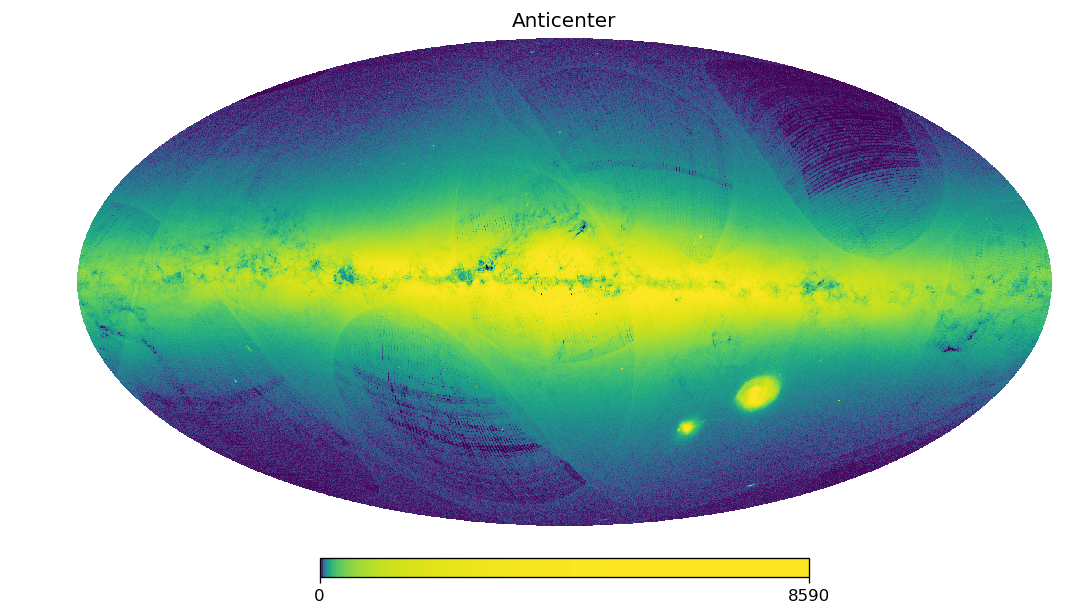

In [34]:
matplotlib.rcParams['figure.dpi'] = 120

hp.mollview(map_, title="Anticenter",
            rot=(266.4, -28.94, 180 - 123), # 17h 45.6m	−28.94°
            #lonra=(-20, 20), latra=(-20, 20), 
            xsize=2400,
            nest=True, norm='hist')